In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import IPython.display as ipd
import pandas as pd
import numpy as np
import seaborn as sns
import librosa
import soundfile as sf
import re
import scipy
import torch
import matplotlib.pyplot as plt
import nnAudio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import gc
import seaborn as sns

from glob import glob
from tqdm import tqdm
from nnAudio.features.mel import MelSpectrogram
from torchaudio.transforms import AmplitudeToDB
from transformers import (
    AutoTokenizer, AutoFeatureExtractor, AutoModelForCTC, 
    AutoProcessor, Wav2Vec2Model, HubertForCTC, 
    HubertModel, Data2VecAudioForCTC, Data2VecAudioModel,
    AutoModelForAudioXVector
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
%matplotlib inline

/tmp/ipykernel_2147863/20051410.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
DEVICE = "cuda"

# Agenda
1. [Why do we need SSL representations?](#Why_do_we_need_SSL_representations)
2. [Moving from librosa to torchaudio/nnAudio](#TorchAudio)
3. [SSL Audio NNs](#SSL_Audio_NNs)
4. [SSL Features for Speaker Classification](#SSL_Features_for_Speaker_Classification)
5. [Homework](#Homework)
6. [Optional Additional Task](#Optional_Additional_Task)

<a id='Why_do_we_need_SSL_representations'></a>
# Why do we need SSL representations?

Our main goal is to train the better model (in terms of metrics) using a smaller amount of training data.

HOWEVER, accumulating lots of unlabeled data is MUCH easier than labeling even a tiny amount of data.

![unlabaled_data](images/unlabaled_data.png)

![data_labeling](images/data_labeling.png)

How can we benefit from lots of unlabeled data?

![transfer_learning](images/transfer_learning.png)

![weak_supervision](images/weak_supervision.png)

![ssl_features](images/ssl_features.png)

<a id='TorchAudio'></a>
# Moving from `librosa` to `torchaudio`/`nnAudio`?

In [3]:
# Refactored from https://chat.openai.com/share/e/52f6acc9-152d-4a99-b874-86998ad8fcc7
def load_and_process_audio(paths, sample_rate=None):
    # Load and resample audio files
    audios = []
    max_length = 0
    for path in tqdm(paths):
        audio, sr = librosa.load(path, sr=sample_rate)
        max_length = max(max_length, len(audio))
        audios.append(audio)

    # Pad audios to have the same length and stack them into a batch
    batched_audio = torch.zeros(len(audios), max_length)  # Assuming mono audio files
    padding_masks = torch.zeros(len(audios), max_length)
    for i, audio in enumerate(audios):
        length = len(audio)
        batched_audio[i, :length] = torch.from_numpy(audio)
        padding_masks[i, :length] = 1  # Mark non-padded areas as 1

    return batched_audio, padding_masks

In [4]:
wave_pathes = glob(
    "../../data/VCTK-Corpus/VCTK-Corpus/wav48/*/*.wav", recursive=True
)
# In case of Windows
wave_pathes = [wave_path.replace('\\', '/') for wave_path in wave_pathes]

speaker2pathes = dict()
for speaker in set([wave_path.split("/")[-2] for wave_path in wave_pathes]):
    speaker2pathes[speaker] = [
        wave_path for wave_path in wave_pathes if wave_path.split("/")[-2] == speaker
    ]

In [5]:
# Ignore it :) I want to pick "hard" line on the first place
speaker2pathes["p279"] = (
    [speaker2pathes["p279"].pop(speaker2pathes["p279"].index("../../data/VCTK-Corpus/VCTK-Corpus/wav48/p279/p279_202.wav"))]
    +
    speaker2pathes["p279"]
)

In [6]:
speaker_audio, speaker_pad_mask = load_and_process_audio(speaker2pathes["p279"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 405/405 [00:01<00:00, 343.27it/s]


In [7]:
speaker_audio.shape, speaker_pad_mask.shape

(torch.Size([405, 456951]), torch.Size([405, 456951]))

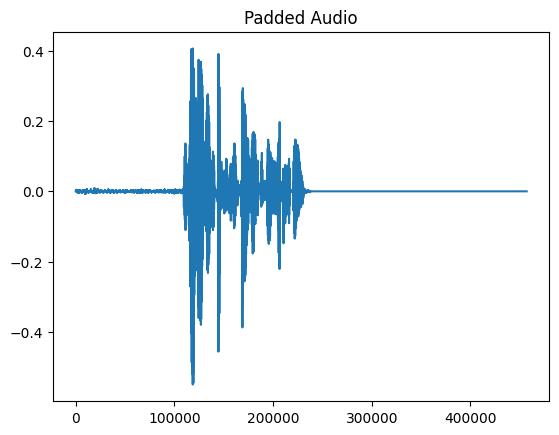

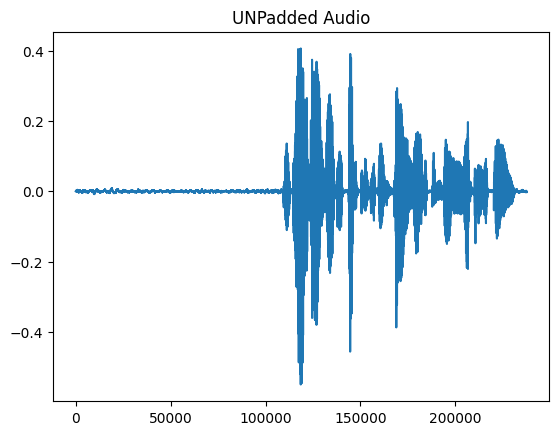

In [8]:
plt.title("Padded Audio")
plt.plot(speaker_audio[0])
plt.show()
plt.title("UNPadded Audio")
plt.plot(speaker_audio[0][speaker_pad_mask[0].bool()])
plt.show()

> <font style="color:red">**TODO**</font>: Implement "UniversalSlicer", which will be able to cut/pad waves to pre-defined length and batch them. Implement different cutting/padding policies, for example, right/left pad, cut to fixed length or by silence regions (2+ points).

[nnAudio Docs](https://kinwaicheuk.github.io/nnAudio/index.html)

![nnAudio_meme](images/nnAudio_meme.jpg)

In [9]:
spec_layer =  nn.Sequential(
    MelSpectrogram(sr=48000),
    AmplitudeToDB(top_db=80)
)

STFT kernels created, time used = 0.0809 seconds
STFT filter created, time used = 0.0023 seconds
Mel filter created, time used = 0.0023 seconds


In [10]:
speaker_spec_10 = spec_layer(speaker_audio[:10])

In [11]:
speaker_spec_10.shape

torch.Size([10, 128, 893])

In [12]:
def extract_pad_digital_silence_from_spec(input_spec):
    amplitude_sum = input_spec.sum(dim=0)
    pad_start = torch.where(amplitude_sum == amplitude_sum.min())[0].min()
    mask = torch.ones_like(amplitude_sum)
    mask[pad_start:] = 0
    return mask

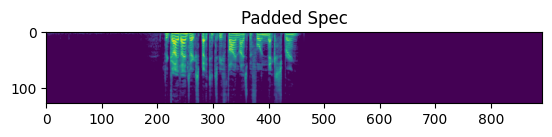

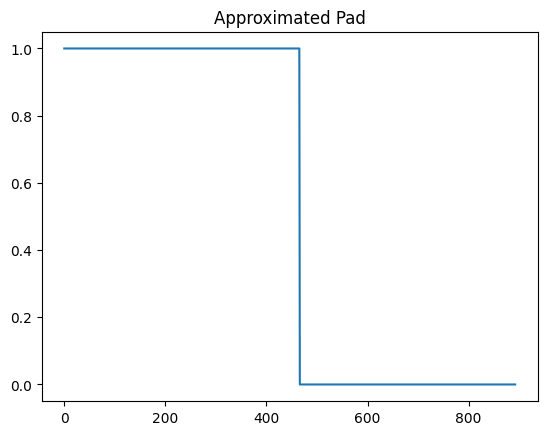

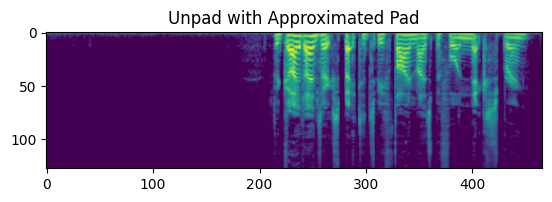

In [13]:
plt.title("Padded Spec")
plt.imshow(speaker_spec_10[0])
plt.show()

approx_pad = extract_pad_digital_silence_from_spec(speaker_spec_10[0])

plt.title("Approximated Pad")
plt.plot(approx_pad)
plt.show()
plt.title("Unpad with Approximated Pad")
plt.imshow(speaker_spec_10[0][:,approx_pad==1])
plt.show()

In [14]:
class Audio2SpecPad(nn.Module):
    def __init__(
        self,
        hop_size=512
    ):
        super().__init__()
        self.maxpool = nn.MaxPool1d(
            kernel_size=hop_size,
            stride=hop_size
        )
    
    def forward(self, audio_pads, time_max_length):
        spec_pads = self.maxpool(audio_pads.unsqueeze(1)).squeeze(1)
        pad = torch.ones(spec_pads.shape[0], time_max_length - spec_pads.shape[-1])
        spec_pads = torch.cat((pad, spec_pads), axis=1)
        return spec_pads
        
audio2spec_pad_layer = Audio2SpecPad()

> <font style="color:red">**TODO**</font>: Rewrite `Audio2SpecPad` and get rid of "hacky pad" (1 point)

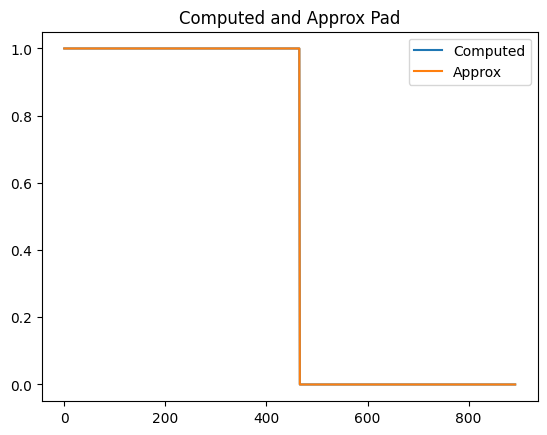

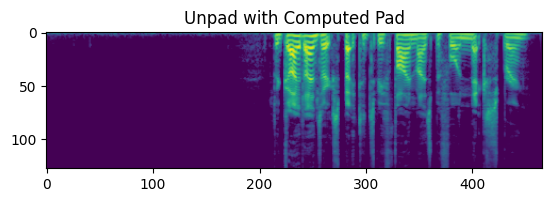

In [15]:
computed_spec_pad = audio2spec_pad_layer(
    speaker_pad_mask[:10], 
    time_max_length=speaker_spec_10.shape[-1]
)

plt.title("Computed and Approx Pad")
plt.plot(computed_spec_pad[0], label="Computed")
plt.plot(approx_pad, label="Approx")
plt.legend()
plt.show()
plt.title("Unpad with Computed Pad")
plt.imshow(speaker_spec_10[0][:,computed_spec_pad[0]==1])
plt.show()

<a id='SSL_Audio_NNs'></a>
# SSL Audio NNs

In [16]:
def parameter_counter(input_model, model_name):
    counter = 0
    for param in input_model.parameters():
        counter += param.shape.numel()
    print(f"{model_name} Parameters Count: {f'{counter/1_000_000:.1f}M'}")

## [Wave2Vec](https://arxiv.org/abs/1904.05862)

Model consists of 2 parts:
- Encoder network $f: X \rightarrow Z$.
- Context network $g: Z \rightarrow C$.

![w2v_logic](images/w2v_logic.png)

The Encoder network produces latent representations, which Context Vector will then predict.

Main ideas:
- Create latent representations containing “averaged for some period” audio information.
- Train Context network, which can “guess” future latent representations.
- Contrastive loss.

![w2v_loss](images/w2v_loss.png)

After the model is trained, we can use the output of Encoder network -> Context network ($f(g(\text{audio}))$) as audio representation, which should contain “plenty of phonetic information”.

![w2v_results](images/w2v_results.png)


Code example is adopted from official HF example:

- [ASR](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2CTCTokenizer).
- [SSL](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2Model).

In [17]:
model = AutoModelForCTC.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained("facebook/wav2vec2-base-960h")
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


In [18]:
parameter_counter(model, "W2V")

W2V Parameters Count: 94.4M


In [19]:
resample_layer = torchaudio.transforms.Resample(
    orig_freq=48000,
    new_freq=16000
)

In [20]:
speaker_audio_10_16k = resample_layer(speaker_audio[:10])

In [21]:
print(f"Time shape decreased {speaker_audio.shape[-1] / speaker_audio_10_16k.shape[-1]} times after resampling")

Time shape decreased 3.0 times after resampling


In [22]:
# Process waves
input_values = feature_extractor([
    el for el in speaker_audio_10_16k.numpy()
], return_tensors="pt").input_values

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


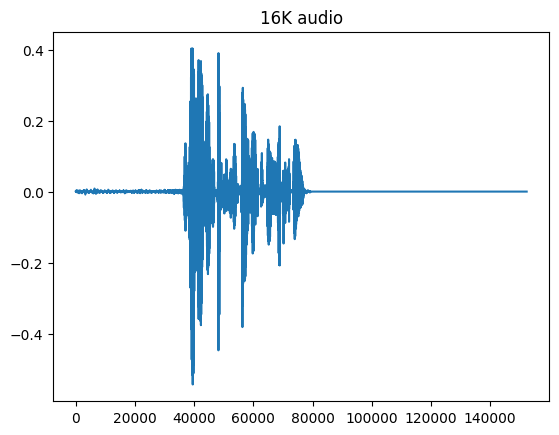

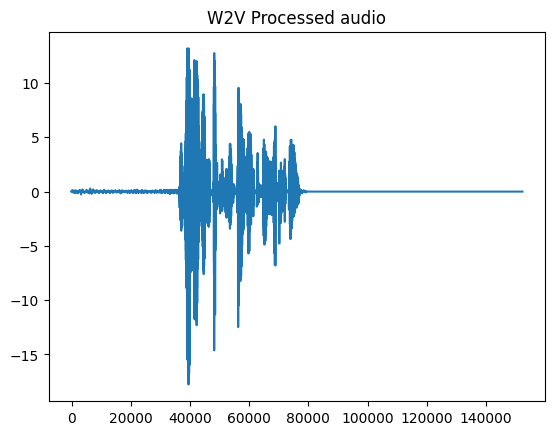

In [23]:
plt.title("16K audio")
plt.plot(speaker_audio_10_16k[0])
plt.show()
plt.title("W2V Processed audio")
plt.plot(input_values[0])
plt.show()

> <font style="color:red">**TODO**</font>: Explore [Wav2Vec2FeatureExtractor](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2FeatureExtractor). Can we rewrite it, so it takes on input batched torch.Tensor ? (1 point)

In [24]:
# Apply Model
with torch.no_grad():
    model_output = model(input_values.cuda())

In [25]:
print(f"Input Shape [B, L]: {input_values.shape}")
print(f"Ouput Shape [B, N_L, C]: {model_output.logits.shape}")

Input Shape [B, L]: torch.Size([10, 152317])
Ouput Shape [B, N_L, C]: torch.Size([10, 475, 32])


I assume that `C` (number of classes) here refer to number of letter in English + a bunch of special symbols. BUT

> **TODO**: Check what does [Wav2Vec2ForCTC("facebook/wav2vec2-base-960h")](https://huggingface.co/facebook/wav2vec2-base-960h) predict ?

In [26]:
# Decode results
pred_ids = torch.argmax(model_output.logits[0], axis=-1)
outputs = tokenizer.decode(pred_ids, output_word_offsets=True)
outputs.text

'THE GYDINES ARE EXPECTED TO BE FINE LINES BEFORE NEXT SPRING'

In [27]:
ipd.Audio(
    data=speaker_audio_10_16k[0],
    rate=16_000
)

In [28]:
!cat {speaker2pathes["p279"][0].replace("wav48", "txt").replace(".wav",".txt")}

The guidelines are expected to be finalised before next spring.


In [29]:
# Free memory 
del model, tokenizer, feature_extractor
torch.cuda.empty_cache()
gc.collect()

3638

But we are not really intersted in ASR now, it is just a cool bonus :)

Lets come back to our SSL features

In [30]:
processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
input_values = processor([
    el for el in speaker_audio_10_16k.numpy()
], sampling_rate=16_000, return_tensors="pt")

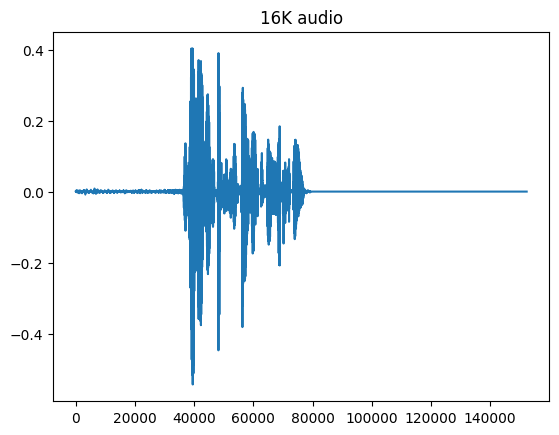

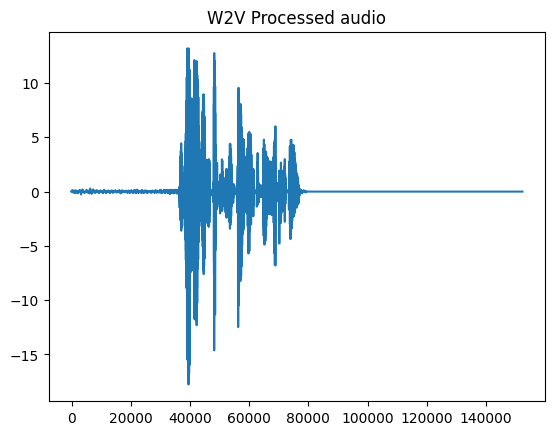

In [32]:
plt.title("16K audio")
plt.plot(speaker_audio_10_16k[0])
plt.show()
plt.title("W2V Processed audio")
plt.plot(input_values.input_values[0])
plt.show()

In [33]:
with torch.no_grad():
    model_output = model(input_values.input_values.cuda())

In [34]:
speaker_w2v_10 = model_output.last_hidden_state.cpu()

In [35]:
print("Reduction Factor (OR Hop Size) from 16K audio:", input_values.input_values.shape[1] / speaker_w2v_10.shape[1])

Reduction Factor (OR Hop Size) from 16K audio: 320.66736842105263


In [36]:
audio2spec_pad_layer = Audio2SpecPad(hop_size=320 * 3)

computed_w2v_pad = audio2spec_pad_layer(
    speaker_pad_mask[:10], 
    time_max_length=speaker_w2v_10.shape[1]
)

In [117]:
speaker_w2v_10.shape

torch.Size([10, 475, 768])

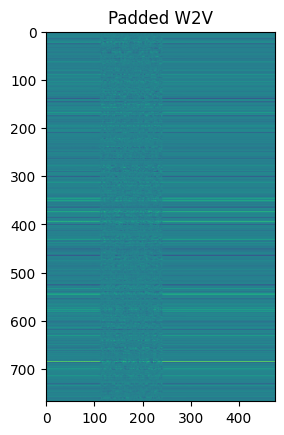

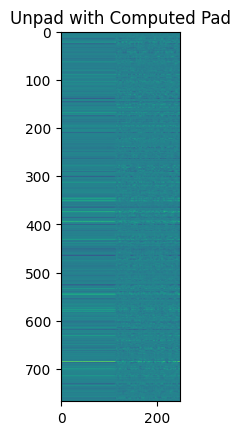

In [37]:
plt.title("Padded W2V")
plt.imshow(speaker_w2v_10[0].T)
plt.show()
plt.title("Unpad with Computed Pad")
plt.imshow(speaker_w2v_10[0][computed_w2v_pad[0]==1].T)
plt.show()

> <span style="color:red">**TODO**</span>: Explore [Wav2Vec2Model](https://huggingface.co/docs/transformers/model_doc/wav2vec2#transformers.Wav2Vec2Model) docs and use `attention_mask` in order to optimize computations and unpad seuqnce in a bettter way (0.5 point).

In [38]:
# Free memory 
del model, processor
torch.cuda.empty_cache()
gc.collect()

10095

## [Hubert](https://arxiv.org/abs/2106.07447)

Model, which is able to predict discrete speech representations.

Overall Pipeline:
1. Cluster MFCC audio representations.
2. Train Masked CNN->Transformer model to predict masked regions.

![hubert_concept](images/hubert_concept.png)

Main ideas:
- Clustered representations may correlate with phonemes.
- In order to “guess” masked regions model should understand audio structure.
- Deeper architecture compared to W2V, in order to create more "high level" audio representations.

![hubert_architecture](images/hubert_architecture.png)

After model is trained we can use HuBERT part to create self supervised audio representations.

![hubert_results](images/hubert_results.png)

Code example is adopted from official HF example:

- [ASR](https://huggingface.co/docs/transformers/model_doc/hubert#transformers.HubertForCTC).
- [SSL](https://huggingface.co/docs/transformers/model_doc/hubert#transformers.HubertModel).

In [39]:
processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForCTC.from_pretrained("facebook/hubert-large-ls960-ft").to(DEVICE)

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


Some weights of the model checkpoint at facebook/hubert-large-ls960-ft were not used when initializing HubertForCTC: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForCTC were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-

In [40]:
parameter_counter(model, "Hubert")

Hubert Parameters Count: 315.5M


In [41]:
input_values = processor([
    el for el in speaker_audio_10_16k.numpy()
], sampling_rate=16_000, return_tensors="pt")

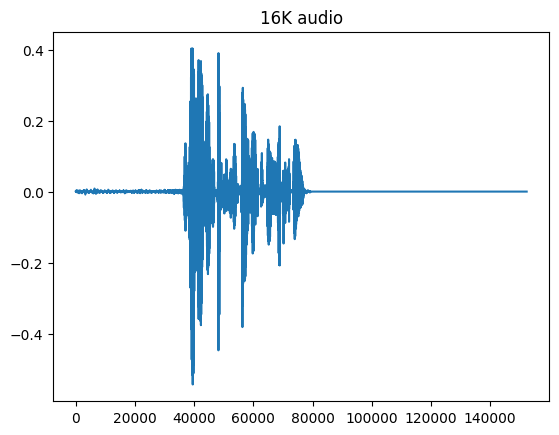

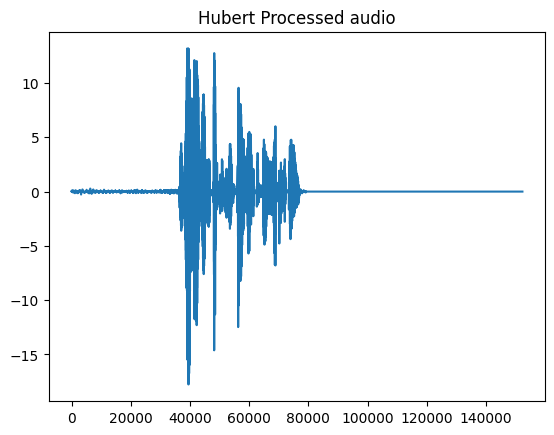

In [42]:
plt.title("16K audio")
plt.plot(speaker_audio_10_16k[0])
plt.show()
plt.title("Hubert Processed audio")
plt.plot(input_values.input_values[0])
plt.show()

In [43]:
with torch.no_grad():
    model_output = model(input_values.input_values.cuda())

In [44]:
print(f"Input Shape [B, L]: {input_values.input_values.shape}")
print(f"Ouput Shape [B, N_L, C]: {model_output.logits.shape}")

Input Shape [B, L]: torch.Size([10, 152317])
Ouput Shape [B, N_L, C]: torch.Size([10, 475, 32])


In [45]:
pred_ids = torch.argmax(model_output.logits[0], axis=-1)
transcription = processor.batch_decode(pred_ids)

In [46]:
transcription[:5]

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

In [47]:
" ".join([el for el in transcription if el!="<pad>"])

'T H E   G U Y D L I N E S   A R E  E X P E C T T E D D  T T O   B E   F I N N A L I Z E D  B E F O R E E    N N E X X T T   S S P R R I N G G   '

> <font style="color:red">**TODO**</font>: Check how to normalize outputs of [HubertForCTC](https://huggingface.co/docs/transformers/model_doc/hubert#transformers.HubertForCTC). *Simply put, make them in a format we had for W2V.* (2 points)

Overall, if we normalize Hubert outputs, we can see that (on this particular sample) it performs better:

- W2V: `GYDINES`, Hubert: `G U Y D L I N E S`, GT: `guidelines`.
- W2V: `FINE LINES`, Hubert: `F I N N A L I Z E D`, GT: `finalised`.

In [48]:
# Free memory 
del model, processor
torch.cuda.empty_cache()
gc.collect()

3584

In [49]:
processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft").to(DEVICE)

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
input_values = processor([
    el for el in speaker_audio_10_16k.numpy()
], sampling_rate=16_000, return_tensors="pt")

In [51]:
with torch.no_grad():
    speaker_hubert_10 = model(input_values.input_values.cuda()).last_hidden_state.cpu()

In [52]:
speaker_hubert_10.shape

torch.Size([10, 475, 1024])

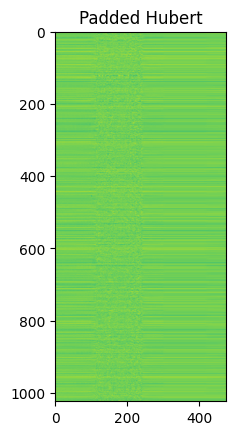

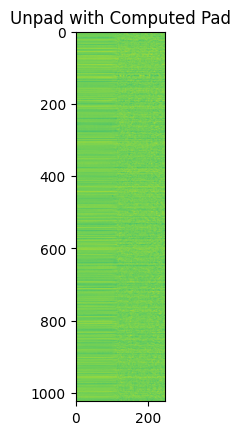

In [53]:
plt.title("Padded Hubert")
plt.imshow(speaker_hubert_10[0].T)
plt.show()
plt.title("Unpad with Computed Pad")
plt.imshow(speaker_hubert_10[0][computed_w2v_pad[0]==1].T)
plt.show()

In [54]:
# Free memory 
del model, processor
torch.cuda.empty_cache()
gc.collect()

6078

## [Data2Vec](https://arxiv.org/pdf/2202.03555.pdf)

Model is distilled to predict its own representations from previous updates, given a masked input

Pipeline:
1. Encode audio sample with the Teacher model.
2. Mask some sample content and encode it with the Student model.
3. Optimize the Student model, so it produces same representation as the Teacher model.
4. Update the Teacher model with Exponential Moving Average of Student's weights.

![d2v_concept](images/d2v_concept.png)

Main ideas:

- It is a kind of combination of Wave2Vec and Hubert ideas.
- Operates only on its own data representations.
- Representations “to predict” come from the transformer.

![d2v_loss](images/d2v_loss.png)

![d2v_results](images/d2v_results.png)

Code example is adopted from official HF example:

- [ASR](https://huggingface.co/docs/transformers/model_doc/data2vec#transformers.Data2VecAudioForCTC).
- [SSL](https://huggingface.co/docs/transformers/model_doc/data2vec#transformers.Data2VecAudioModel).

In [55]:
processor = AutoProcessor.from_pretrained("facebook/data2vec-audio-base-960h")
model = Data2VecAudioForCTC.from_pretrained("facebook/data2vec-audio-base-960h").to(DEVICE)

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


In [56]:
parameter_counter(model, "D2V")

D2V Parameters Count: 93.2M


In [57]:
input_values = processor([
    el for el in speaker_audio_10_16k.numpy()
], sampling_rate=16_000, return_tensors="pt")

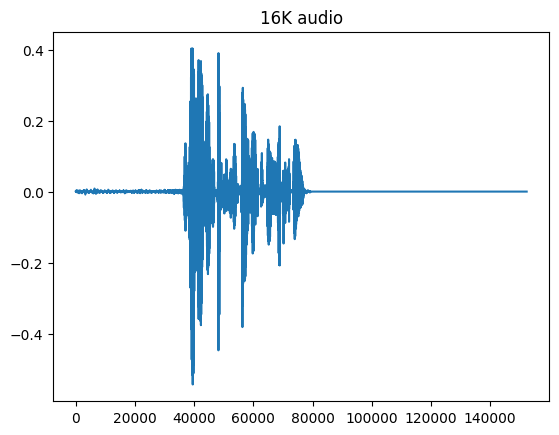

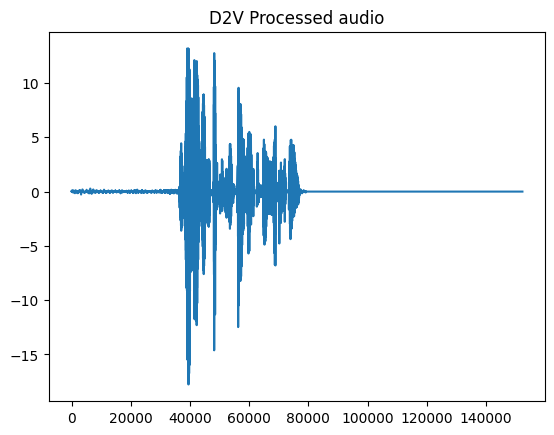

In [58]:
plt.title("16K audio")
plt.plot(speaker_audio_10_16k[0])
plt.show()
plt.title("D2V Processed audio")
plt.plot(input_values.input_values[0])
plt.show()

In [59]:
with torch.no_grad():
    model_output = model(input_values.input_values.cuda())

In [60]:
print(f"Input Shape [B, L]: {input_values.input_values.shape}")
print(f"Ouput Shape [B, N_L, C]: {model_output.logits.shape}")

Input Shape [B, L]: torch.Size([10, 152317])
Ouput Shape [B, N_L, C]: torch.Size([10, 475, 32])


In [61]:
pred_ids = torch.argmax(model_output.logits[0], axis=-1)
transcription = processor.batch_decode(pred_ids)

In [62]:
transcription[:5]

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

In [63]:
" ".join([el for el in transcription if el!="<pad>"])

'    T H E    G U Y L I N E S S  A R E   E X P E C T T E D   T O   B E   F I N E L I N E S S   B E F O R E       N E X T T  S P P R R I N N G    '

Overall, if we normalize D2V outputs, we can see that (on this particular sample) it performs the worst :) :

- W2V: `GYDINES`, Hubert: `G U Y D L I N E S`, D2V: `G U Y L I N E S S`, GT: `guidelines`
- W2V: `FINE LINES`, Hubert: `F I N N A L I Z E D`, D2V: `F I N E L I N E S S`, GT: `finalised`

In [64]:
# Free memory 
del model, processor
torch.cuda.empty_cache()
gc.collect()

3474

In [65]:
processor = AutoProcessor.from_pretrained("facebook/data2vec-audio-base-960h")
model = Data2VecAudioModel.from_pretrained("facebook/data2vec-audio-base-960h").to(DEVICE)

Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize
Ignored unknown kwarg option normalize


In [66]:
with torch.no_grad():
    speaker_d2v_10 = model(input_values.input_values.cuda()).last_hidden_state.cpu()

In [67]:
speaker_d2v_10.shape

torch.Size([10, 475, 768])

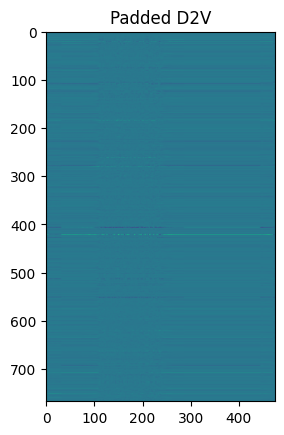

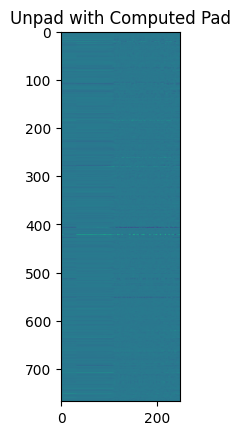

In [68]:
plt.title("Padded D2V")
plt.imshow(speaker_d2v_10[0].T)
plt.show()
plt.title("Unpad with Computed Pad")
plt.imshow(speaker_d2v_10[0][computed_w2v_pad[0]==1].T)
plt.show()

In [69]:
# Free memory 
del model, processor
torch.cuda.empty_cache()
gc.collect()

6526

## How to benchmark SSL models ?

The most popular approach is [SUPERB: Speech processing Universal PERformance Benchmark](https://arxiv.org/abs/2105.01051).

Using this benchmark, we evaluate SSL models (SSL Model -> "Head") on the following tasks:

- Phoneme Recognition, PR.
- Automatic Speech Recognition, ASR.
- Keyword Spotting, KS.
- Query by Example Spoken Term Detection, QbE.
- Speaker Identification, SID.
- Automatic Speaker Verification, ASV.
- Speaker Diarization, SD.
- Intent Classification, IC.
- Slot Filling, SF.
- Emotion Recognition, ER.

Explore best models on interactive [Leaderboard](https://superbbenchmark.org/leaderboard).

## One interesting common thing with all these models

`facebook/...`

[Yann LeCun On How An Open Source Approach Could Shape AI](https://www.time.com/6691705/time100-impact-awards-yann-lecun/)

![Yann_LeCun](images/Yann_LeCun.png)

<a id='SSL_Features_for_Speaker_Classification'></a>
# SSL Features for Speaker Classification

## Prepare Data

In [70]:
# Created by ChatGPT: https://chat.openai.com/share/e/0fe06227-eedf-4228-8845-48152d32d4a7
def read_file_content(file_path):
    """
    Reads the content of a text file and returns it as a string.

    Parameters:
    file_path (str): The path to the .txt file to be read.

    Returns:
    str: The content of the file as a string.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read().rstrip('\n')
        return content
    except FileNotFoundError:
        return None
    except Exception as e:
        return f"An error occurred: {e}"


In [71]:
vctk_df  = pd.DataFrame({
    "filename": wave_pathes
})

In [72]:
vctk_df.filename.iloc[0]

'../../data/VCTK-Corpus/VCTK-Corpus/wav48/p225/p225_001.wav'

In [73]:
vctk_df["speaker"] = vctk_df["filename"].apply(lambda x: int(x.split("/")[-2][1:]))
vctk_df["text_id"] = vctk_df["filename"].apply(lambda x: int(os.path.splitext(os.path.basename(x))[0].split("_")[1]))

In [74]:
vctk_df["text"] = vctk_df["filename"].apply(lambda x: read_file_content(x.replace("wav48", "txt").replace(".wav",".txt")))

In [75]:
vctk_df.groupby("text_id")["text"].apply(set).iloc[5]

{'"When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow. "',
 None,
 'When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow.',
 'When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow. ',
 'When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow. )',
 'When the sunlight strikes the raindrops in the air, they act as a prism and form a rainbow.'}

In [76]:
unique_text = len(set(vctk_df["text_id"]))
print("Unique texts:", unique_text)

Unique texts: 503


In [77]:
test_text_id = sorted(set(vctk_df["text_id"]))[-150:]
test_text_id[:10]

[354, 355, 356, 357, 358, 359, 360, 361, 362, 363]

In [78]:
# train_df, test_df = (
#     vctk_df[~vctk_df["text_id"].isin(test_text_id)].reset_index(drop=True), 
#     vctk_df[vctk_df["text_id"].isin(test_text_id)].reset_index(drop=True)
# )

In [79]:
# # Uncomment it to download
# !kaggle datasets download -d vladimirsydor/vctk-xvectors
# !unzip vctk-xvectors.zip -d ../../data/vctk_xvectors
# # Correct next pathes 

In [80]:
# train_df.to_csv("../../data/vctk_ssl_features/train.csv", index=False)
# test_df.to_csv("../../data/vctk_ssl_features/test.csv", index=False)

In [81]:
train_df = pd.read_csv("../../data/vctk_xvectors/train.csv")
test_df = pd.read_csv("../../data/vctk_xvectors/test.csv")

In [82]:
assert not set(train_df["text_id"]) & set(test_df["text_id"])

In [83]:
print("Speakers 'missing' in train set", set(test_df["speaker"]) - set(train_df["speaker"]))
print("Speakers 'missing' in test set", set(train_df["speaker"]) -  set(test_df["speaker"]))

Speakers 'missing' in train set set()
Speakers 'missing' in test set {256, 265, 364, 237, 302, 303, 376}


In [84]:
print( 
    (vctk_df[vctk_df["text_id"].isin(test_text_id)].shape[0] / vctk_df.shape[0]) * 100,
    "% of samples in test",
)

15.112336693639527 % of samples in test


In [85]:
train_df["speaker"].value_counts()

speaker
248    353
360    353
301    353
239    353
329    353
      ... 
302    311
364    301
376    292
225    222
315    151
Name: count, Length: 109, dtype: int64

In [86]:
test_df["speaker"].value_counts()

speaker
236    150
239    150
264    141
250    141
259    128
      ... 
306      7
246      7
245      6
260      4
249      1
Name: count, Length: 102, dtype: int64

In [87]:
target_label_encoder = LabelEncoder().fit(train_df["speaker"])
train_y = target_label_encoder.transform(train_df["speaker"])
test_y = target_label_encoder.transform(test_df["speaker"])

In [88]:
train_y

array([29, 29, 29, ...,  2,  2,  2])

In [89]:
test_y

array([73, 73, 73, ...,  2,  2,  2])

## Naive Baselines

In [90]:
def compute_score(
    y_true,
    y_pred
):
    print("accuracy", accuracy_score(y_true, y_pred))
    print("f1", f1_score(y_true, y_pred, average="micro"))

In [91]:
train_random_predict = np.random.randint(low=train_y.min(), high=train_y.max() + 1, size=train_y.shape)
test_random_predict = np.random.randint(low=train_y.min(), high=train_y.max() + 1, size=test_y.shape)

In [92]:
print("Train Random Scores")
compute_score(train_y, train_random_predict)
print("Test Random Scores")
compute_score(test_y, test_random_predict)

Train Random Scores
accuracy 0.00918628181915007
f1 0.00918628181915007
Test Random Scores
accuracy 0.007328746634759198
f1 0.007328746634759198


In [93]:
def find_most_frequent_element(arr):
    """
    Finds and returns the most frequent element in the given numpy array.

    Parameters:
    arr (numpy.ndarray): The input numpy array.

    Returns:
    int or float: The most frequent element in the array.
    """
    # Find unique elements and their counts
    unique_elements, counts = np.unique(arr, return_counts=True)

    # Find the index of the element with the highest count
    max_count_index = np.argmax(counts)

    # The most frequent element
    most_frequent_element = unique_elements[max_count_index]

    return most_frequent_element

In [94]:
train_most_popular_predict = np.full_like(train_y, find_most_frequent_element(train_y))
test_most_popular_predict = np.full_like(test_y, find_most_frequent_element(test_y))

In [95]:
print("Train Most Popular Scores")
compute_score(train_y, train_most_popular_predict)
print("Test Most Popular Scores")
compute_score(test_y, test_most_popular_predict)

Train Most Popular Scores
accuracy 0.009399297049739056
f1 0.009399297049739056
Test Most Popular Scores
accuracy 0.02243493867783428
f1 0.02243493867783428


## Compute features Class

In [96]:
class XVectorExtractor:
    def __init__(
        self,
        model_name,
        device="cpu",
        do_normalize=True
    ):
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.model = AutoModelForAudioXVector.from_pretrained(model_name).to(device)
        self.do_normalize = do_normalize

    def extract_features(
        self,
        wave_pathes,
        sample_rate
    ):
        features = []
        for wave_path in tqdm(wave_pathes):
            wave, _ = librosa.load(wave_path, sr=sample_rate)
            inputs = self.feature_extractor([wave], sampling_rate=sample_rate, return_tensors="pt").input_values
            with torch.no_grad():
                embeddings = self.model(inputs.cuda()).embeddings
            if self.do_normalize:
                embeddings = torch.nn.functional.normalize(embeddings, dim=-1)
            embeddings = embeddings.cpu()
            features.append(embeddings)
        return torch.cat(features, dim=0)

> <font style="color:red">**TODO**</font>: Add batching (1 point).

> <font style="color:red">**TODO**</font>: How to transform `Wav2Vec2Model` into `Wav2Vec2ForXVector` (0.5 point)?

## W2V 2.0

Explore what is new compared to W2V in [paper](https://arxiv.org/abs/2006.11477).

In [97]:
w2v2_xvector_model = XVectorExtractor(
    model_name="anton-l/wav2vec2-base-superb-sv",
    device="cuda",
    do_normalize=True
)

Some weights of the model checkpoint at anton-l/wav2vec2-base-superb-sv were not used when initializing Wav2Vec2ForXVector: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForXVector from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForXVector from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForXVector were not initialized from the model checkpoint at anton-l/wav2vec2-base-superb-sv and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should pr

In [98]:
w2v2_xvector_model.extract_features(train_df.filename.iloc[:2], sample_rate=16_000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s]


tensor([[-0.0137, -0.0238, -0.0223,  ..., -0.0190, -0.0230, -0.0218],
        [-0.0140, -0.0213, -0.0178,  ..., -0.0177, -0.0237, -0.0208]])

In [99]:
# train_w2v2_embs = w2v2_xvector_model.extract_features(
#     train_df.filename.to_list(), 
#     sample_rate=16_000
# )
# test_w2v2_embs = w2v2_xvector_model.extract_features(
#     test_df.filename.to_list(), 
#     sample_rate=16_000
# )

In [100]:
# np.save("../../data/vctk_ssl_features/w2v2_train_xvectors.npy", train_w2v2_embs.numpy())
# np.save("../../data/vctk_ssl_features/w2v2_test_xvectors.npy", test_w2v2_embs.numpy())

In [101]:
train_w2v2_embs = np.load("../../data/vctk_xvectors/w2v2_train_xvectors.npy")
test_w2v2_embs = np.load("../../data/vctk_xvectors/w2v2_test_xvectors.npy")

In [102]:
classification_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

In [103]:
classification_pipeline.fit(train_w2v2_embs, train_y)

Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

In [104]:
train_w2v2_predict = classification_pipeline.predict(train_w2v2_embs)
test_w2v2_predict = classification_pipeline.predict(test_w2v2_embs)

In [105]:
print("Train W2V Scores")
compute_score(train_y, train_w2v2_predict)
print("Test W2V Scores")
compute_score(test_y, test_w2v2_predict)

Train W2V Scores
accuracy 1.0
f1 1.0
Test W2V Scores
accuracy 0.9156446305713432
f1 0.9156446305713432


In [106]:
# Free memory 
del w2v2_xvector_model
torch.cuda.empty_cache()
gc.collect()

195

## D2V

In [107]:
d2v_xvector_model = XVectorExtractor(
    model_name="facebook/data2vec-audio-base-960h",
    device="cuda",
    do_normalize=True
)

Some weights of Data2VecAudioForXVector were not initialized from the model checkpoint at facebook/data2vec-audio-base-960h and are newly initialized: ['tdnn.1.kernel.bias', 'tdnn.4.kernel.bias', 'tdnn.4.kernel.weight', 'tdnn.0.kernel.weight', 'tdnn.0.kernel.bias', 'tdnn.3.kernel.weight', 'tdnn.3.kernel.bias', 'objective.weight', 'tdnn.2.kernel.bias', 'projector.weight', 'feature_extractor.weight', 'tdnn.1.kernel.weight', 'classifier.bias', 'classifier.weight', 'feature_extractor.bias', 'tdnn.2.kernel.weight', 'projector.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [108]:
# train_d2v_embs = d2v_xvector_model.extract_features(
#     train_df.filename.to_list(), 
#     sample_rate=16_000
# )
# test_d2v_embs = d2v_xvector_model.extract_features(
#     test_df.filename.to_list(), 
#     sample_rate=16_000
# )

In [109]:
# np.save("../../data/vctk_ssl_features/d2v_train_xvectors.npy", train_d2v_embs.numpy())
# np.save("../../data/vctk_ssl_features/d2v_test_xvectors.npy", test_d2v_embs.numpy())

In [110]:
train_d2v_embs = np.load("../../data/vctk_xvectors/d2v_train_xvectors.npy")
test_d2v_embs = np.load("../../data/vctk_xvectors/d2v_test_xvectors.npy")

In [111]:
classification_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

In [112]:
classification_pipeline.fit(train_d2v_embs, train_y)

/home/vova/src/exps/ucu_audio_processing_course/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

In [113]:
train_d2v_predict = classification_pipeline.predict(train_d2v_embs)
test_d2v_predict = classification_pipeline.predict(test_d2v_embs)

In [114]:
print("Train D2V Scores")
compute_score(train_y, train_d2v_predict)
print("Test D2V Scores")
compute_score(test_y, test_d2v_predict)

Train D2V Scores
accuracy 0.5886143359250187
f1 0.5886143359250187
Test D2V Scores
accuracy 0.25964702363146874
f1 0.25964702363146874


<a id='Homework'></a>
# Homework

Theory (5 points):
- Follow links.
- Try to fill/do **TODO** comments.
- Answer theory questions in the Google Form.

Practice (10 points):

Implement Phoneme Recognition (PR) model using SSL features.

1. Take [TIMIT Dataset](https://huggingface.co/datasets/timit_asr).
2. Build model based on SSL features:
    - Try several SSL models — you can take models from lecture or/and explore [HF Model Hub](https://huggingface.co/models) or/and explore [Superb Leaderboard](https://superbbenchmark.org/leaderboard).
    - In lecture we have used `last_hidden_state`. Experiment with other layers, as an example check [Hubert/4 Experimental Details/C](https://arxiv.org/abs/2106.07447).
    - Experiment with different "Heads": Linear, MLP, Recurrent (GRU, LSTM), Conv, Attention. DO NOT use "too Deep" heads.

4. Use PER (Phonem Error Rate) for evaluation. Use pre-defined train/test split.

Example: https://www.kaggle.com/code/vitouphy/phoneme-recognition-with-wav2vec2.

<a id='Optional_Additional_Task'></a>
# Optional Additional Task

**10 Points**

Voice Conversion based on:
- SSL features.
- KNN (K Nearest Neighbors).
- Vocoding from SSL features.

Resources:
- [Code](https://arxiv.org/abs/2305.18975).
- [Paper](https://github.com/bshall/knn-vc).

Apply the proposed approach using another SSL features (they have used WavLM):

- Try 2-3 another SSL features and different layers.
- Do Voice Conversion on VCTK.
- Train Vocoder on LIBRISPEECH or/and VCTK.
- Compare results with paper results. 